# Histopathologic Cancer Detection (Kaggel Project)

## Load data for Google Colab

## Step 1: Brief description of the problem and data

### Problem Description
The goal of this project is to train a model that is capable of identifying metastatic cancer in small image patches taken from larger digital pathology scans [1].

### Data
The PatchCamelyon (PCam) benchmark is an image classification dataset containing 327,680 96x96 color images from histopathologic lymph node scans, each labeled with a binary indication of metastatic tissue. It serves as a middle-ground benchmark for machine learning models, larger than CIFAR-10 but smaller than ImageNet, and is trainable on a single GPU. It has been slightly modified for Kaggle. [1], [2]

The Kaggel data contains two folders with train and test images:
- 219995 images for training
- 57428 images for testing.

It also contains the labels for the training labels.


### Data Handling on Colab

In [1]:
import os
print(os.listdir('/content'))

['.config', 'train_labels.csv', 'drive', 'test', 'sample_submission.csv', 'train', 'histopathologic-cancer-detection.zip', 'sample_data']


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/DTSA-Project/'
drive_contents = os.listdir(path)
drive_contents

['sample_submission.csv',
 'histopathologic-cancer-detection.zip',
 'train_labels.csv',
 'histopathologic-cancer-detection',
 'submission.csv',
 'final-project-colab.ipynb',
 'final_project_colab_training.ipynb',
 'final_project_colab_training-1.ipynb']

In [4]:
import shutil

# Copy the file from Google Drive to Colab
source_path = path + 'histopathologic-cancer-detection.zip'
destination_path = '/content/histopathologic-cancer-detection.zip'

shutil.copy(source_path, destination_path)
print("File copied successfully.")

File copied successfully.


In [5]:
import zipfile

# Unpack zip file
destination_folder = '/content/'
with zipfile.ZipFile(destination_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print("Zip file extracted successfully.")

Zip file extracted successfully.


### Imports and checks

In [6]:
# Core Libraries
import os
import random
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Handling
from PIL import Image

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras.layers import (
    Dense, GlobalAveragePooling2D, Dropout, Conv2D,
    MaxPooling2D, Flatten, BatchNormalization
)
from tensorflow.keras.models import Model, Sequential, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision

# Device Management
from tensorflow.python.client import device_lib

# Keras
import keras

In [7]:
# Check Keras version
print(keras.__version__)

# Check Tensorflow version
print(tf.__version__)

# Check GPU
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

3.5.0
2.17.1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5754853645924336277
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40427651072
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12206192955971910474
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Step 2: EDA

Sample images and class distribution.

### Load labels and connect to file names

In [8]:
path = '/content/'

# Load the CSV
labels_df = pd.read_csv(path + 'train_labels.csv')
labels_df['label'] = labels_df['label'].astype(str)

# Add extension and path
labels_df['filename'] = labels_df['id'].apply(lambda x: x + '.tif')
image_dir = path + 'train'
labels_df['filepath'] = labels_df['filename'].apply(lambda x: os.path.join(image_dir, x))

labels_df.head()

,id,label,filename,filepath
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif,/content/train/f38a6374c348f90b587e046aac60799...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,/content/train/c18f2d887b7ae4f6742ee445113fa1a...
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif,/content/train/755db6279dae599ebb4d39a9123cce4...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,/content/train/bc3f0c64fb968ff4a8bd33af6971eca...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif,/content/train/068aba587a4950175d04c680d38943f...


In [9]:
labels_df.shape

(220025, 4)

The table with the training labels consists of 220,025 rows and 2 columns. After adding the file names and file paths for further processing, the DataFrame has 4 columns. The 'train' folder contains one image per row, while the 'test' folder holds test images for which labels need to be predicted for the competition.

### Sample Images

Found 100 validated image filenames belonging to 2 classes.


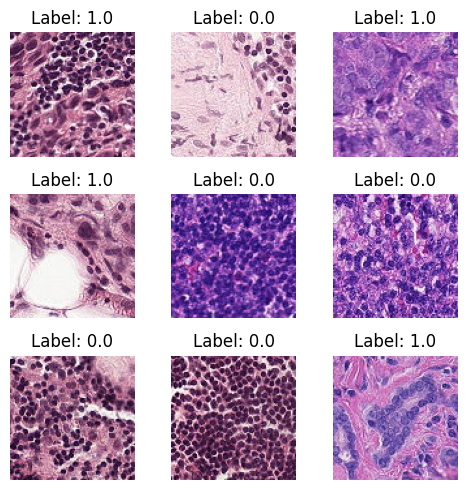

In [10]:
labels_df_sample = labels_df.sample(n=100)

# Load images and labels
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df_sample,
    x_col='filepath',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Plot sample images
images, labels = next(train_generator)

plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### Class Distribution

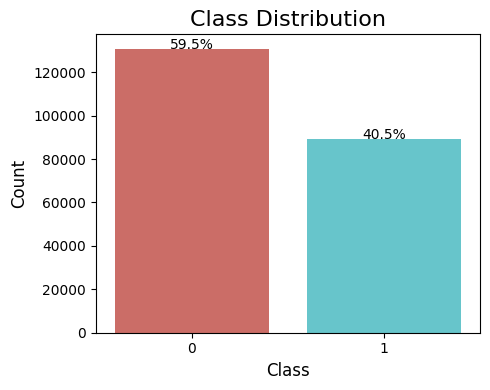

In [11]:
# Percentages
class_counts = labels_df['label'].value_counts(normalize=True) * 100

# Plot histogram with percentages
plt.figure(figsize=(5, 4))
sns.countplot(x='label', data=labels_df, palette='hls', hue='label', legend=False)

for p in plt.gca().patches:
    height = p.get_height()
    percentage = (height / len(labels_df)) * 100
    plt.text(p.get_x() + p.get_width() / 2., height - 5, f'{percentage:.1f}%',
             ha='center', fontsize=10)

# Plot
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()
plt.show()



### Color Distribution

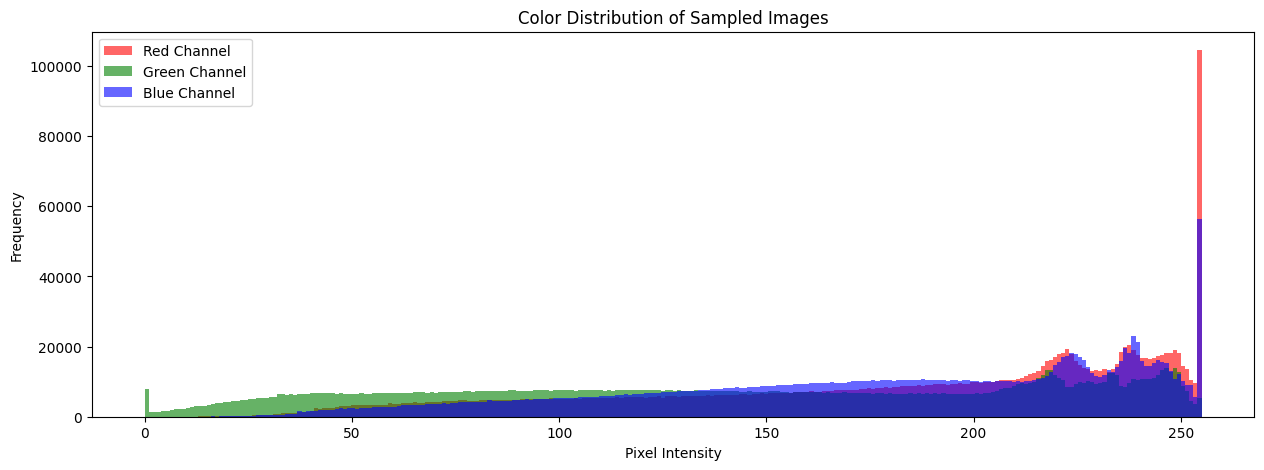

In [12]:
sample_size = 200
sampled_df = labels_df.sample(n=sample_size, random_state=42)

# Initialize RGB lists
reds, greens, blues = [], [], []

for filepath in sampled_df['filepath']:
    try:
        img = Image.open(filepath)

        img_array = np.array(img)

        # Extract RGB channels
        reds.append(img_array[:, :, 0].flatten())
        greens.append(img_array[:, :, 1].flatten())
        blues.append(img_array[:, :, 2].flatten())
    except Exception as e:
        print(f"Error processing {filepath}: {e}")

# Flatten and plot
reds = np.concatenate(reds)
greens = np.concatenate(greens)
blues = np.concatenate(blues)

plt.figure(figsize=(15, 5))
plt.hist(reds, bins=256, color='red', alpha=0.6, label='Red Channel')
plt.hist(greens, bins=256, color='green', alpha=0.6, label='Green Channel')
plt.hist(blues, bins=256, color='blue', alpha=0.6, label='Blue Channel')
plt.title('Color Distribution of Sampled Images')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### EDA Conclusion
- There are two class labels: 0 and 1.
- The data is not perfectly balanced but is also not highly skewed; therefore, no action is required.
- Paths and filenames have been added for further processing.
- The distributions of the RGB channels indicate that the channels contain complementary information.

### Preprocessing and Augmentation and Normalization

The following augemtations will be applied when defining the data generators later:
- **Rescaling**: Preprocessing for normalized inputs.
- **Geometric Transformations**:
  - Rotation (±15°)
  - Horizontal and vertical shifts (10% of dimensions)
  - Horizontal flipping

### Next Steps and Analysis Approach
Two model types will be trained using an Nvidia A100 GPU on Google Colab: 1) A small custom CNN, including basic hyperparameter tuning, and 2) transfer learning with MobileNetV2 as the base model.

## Step 3: Model Architecture

### (Small) CNN from scratch
The convolutional layers (32, 64, 128 filters) progressively extract features from the images, with BatchNormalization and MaxPooling2D helping to stabilize training and reduce size. The fully connected layers, with dropout for regularization, make the final predictions, and the sigmoid output layer provides binary classification results.

- Convolutional Layers:
  - Conv2D: 32 filters, kernel size (3, 3), ReLU activation, followed by BatchNormalization and MaxPooling2D with pool size (2, 2).
  - Conv2D: 64 filters, kernel size (3, 3), ReLU activation, followed by BatchNormalization and MaxPooling2D with pool size (2, 2).
  - Conv2D: 128 filters, kernel size (3, 3), ReLU activation, followed by BatchNormalization and MaxPooling2D with pool size (2, 2).

The increasing number of filters in convolutional layers allows the model to learn progressively more complex and abstract features from the input data.
  
- Fully Connected Layers:
  - Flatten: Flatten the 3D output of the convolutional layers to 1D.
  - Dense: 128 units, ReLU activation.
  - Dropout: 50% regularization to prevent overfitting.
  - Dense: 1 unit, Sigmoid activation for binary classification output.

- Output Layer: A binary classification output (0 or 1).

### Transfer learning: MobileNetV2 with custom classification layers
Considering the size of the dataset and the limited GPU resources available for this project, transfer learning was chosen as an additional method. MobileNetV2 was chosen as base model due to resource limitations.

The following custom layers were added:
- GlobalAveragePooling2D: Reduces the dimensionality by averaging the feature map across spatial dimensions (height and width).
- Dropout Layer 1: Dropout rate of 20% to prevent overfitting by randomly setting a fraction of input units to zero during training.
- Dense Layer with ReLU activation: 128 units with ReLU activation, allowing the model to learn more complex patterns.
- Dropout Layer 2: Dropout rate of 20% to further prevent overfitting.
- Output Layer: A single unit with sigmoid activation, used for binary classification (outputting a value between 0 and 1).

## Step 4: Results and Analysis

### Data generators

In [13]:
# Data Generators
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    x_col='filepath',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation data generator
val_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    x_col='filepath',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### (Small) CNN from scratch

In [14]:
model_seq = Sequential([
    # Convolutional Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Layer 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_seq.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC', Precision()]
)

# Summary of the model
model_seq.summary()

# Train the model
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

model_seq.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=3,
    validation_data=val_generator,
    validation_steps=validation_steps
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 94, 94, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,732,801 (6.61 MB)

 Trainable params: 1,732,353 (6.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 633s 114ms/step - AUC: 0.8617 - accuracy: 0.8015 - loss: 0.5250 - precision: 0.7865 - val_AUC: 0.9239 - val_accuracy: 0.8050 - val_loss: 0.4874 - val_precision: 0.9561
Epoch 2/3
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - AUC: 0.9372 - accuracy: 0.9062 - loss: 0.2830 - precision: 0.9000

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1s 129us/step - AUC: 0.9372 - accuracy: 0.9062 - loss: 0.2830 - precision: 0.9000 - val_AUC: 0.7500 - val_accuracy: 0.4000 - val_loss: 1.0453 - val_precision: 1.0000
Epoch 3/3
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 619s 112ms/step - AUC: 0.9298 - accuracy: 0.8647 - loss: 0.3348 - precision: 0.8703 - val_AUC: 0.8414 - val_accuracy: 0.7505 - val_loss: 0.6670 - val_precision: 0.9615


### (Small) CNN from scratch: hyperparameter tuning

The hyperparameter tuning approach involves different combinations of learning rates, dropout rates, and batch sizes to identify the optimal set for the model. Specifically, the learning rates tested are 0.01, and 0.001; dropout rates of 0.3, and 0.5; and batch sizes of 32, and 128.

In [15]:
# Parameter ranges
learning_rates = [0.01, 0.001]
dropout_rates = [0.3, 0.5]
batch_sizes = [32, 128]

# Model Tracking
best_val_acc = 0
best_model = None
best_history = None

# Collect history
histories = []

for lr in learning_rates:
    for dropout in dropout_rates:
        for batch_size in batch_sizes:

            model_seq_hyper = Sequential([
                # Convolutional Layer 1
                Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
                BatchNormalization(),
                MaxPooling2D(pool_size=(2, 2)),

                # Convolutional Layer 2
                Conv2D(64, (3, 3), activation='relu'),
                BatchNormalization(),
                MaxPooling2D(pool_size=(2, 2)),

                # Convolutional Layer 3
                Conv2D(128, (3, 3), activation='relu'),
                BatchNormalization(),
                MaxPooling2D(pool_size=(2, 2)),

                # Flatten and Fully Connected Layers
                Flatten(),
                Dense(128, activation='relu'),
                Dropout(dropout),
                Dense(1, activation='sigmoid')
            ])

            # Recompile
            model_seq_hyper.compile(
                optimizer=Adam(learning_rate=lr),
                loss='binary_crossentropy',
                metrics=['accuracy', 'AUC', Precision()]
            )

            # Train model
            print(f"Training with learning_rate={lr}, dropout={dropout}, batch_size={batch_size}...")
            history = model_seq_hyper.fit(
                train_generator,
                validation_data=val_generator,
                epochs=2,
                steps_per_epoch=steps_per_epoch,
                validation_steps=validation_steps,
                batch_size=batch_size
            )

            histories.append(history)

            val_acc = max(history.history['val_accuracy'])
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = model_seq_hyper
                best_history = history

print(f"Best model validation accuracy: {best_val_acc}")

Training with learning_rate=0.01, dropout=0.3, batch_size=32...
Epoch 1/2
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 627s 113ms/step - AUC: 0.8146 - accuracy: 0.7667 - loss: 1.1728 - precision_1: 0.7899 - val_AUC: 0.8448 - val_accuracy: 0.7530 - val_loss: 0.5222 - val_precision_1: 0.9593
Epoch 2/2
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 70us/step - AUC: 0.8730 - accuracy: 0.7188 - loss: 0.5929 - precision_1: 0.7778 - val_AUC: 0.8750 - val_accuracy: 0.4000 - val_loss: 0.8571 - val_precision_1: 1.0000
Training with learning_rate=0.01, dropout=0.3, batch_size=128...
Epoch 1/2
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 624s 112ms/step - AUC: 0.8351 - accuracy: 0.7745 - loss: 1.3852 - precision_2: 0.7877 - val_AUC: 0.9046 - val_accuracy: 0.8276 - val_loss: 0.4129 - val_precision_2: 0.7955
Epoch 2/2
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 75us/step - AUC: 0.8983 - accuracy: 0.8438 - loss: 0.4054 - precision_2: 0.7500 - val_AUC: 0.6250 - val_accuracy: 0.6000 - val_loss: 0.5262 - val_precision_2: 0.7500
Training with learning_ra

### MobileNetV2 with custom classification layers

In [16]:
input_shape = (96, 96, 3)

# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(include_top=False, weights='imagenet',
                         input_shape=input_shape)

# Freeze base model (no fine tuning)
base_model.trainable = False

# Custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

# Defien and compile the model
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', Precision()])

model.summary()

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 48, 48, 32)     │            864 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 48, 48, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 48, 48, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 48, 48, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 48, 48, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 48, 48, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 48, 48, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 48, 48, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 48, 48, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 48, 48, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 48, 48, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 49, 49, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 24, 24, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 646s 116ms/step - AUC: 0.8941 - accuracy: 0.8212 - loss: 0.3985 - precision_9: 0.8034 - val_AUC: 0.9254 - val_accuracy: 0.8522 - val_loss: 0.3389 - val_precision_9: 0.8558
Epoch 2/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision_9: 0.0000e+00
Epoch 3/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 625s 114ms/step - AUC: 0.9170 - accuracy: 0.8447 - loss: 0.3546 - precision_9: 0.8356 - val_AUC: 0.9310 - val_accuracy: 0.8594 - val_loss: 0.3272 - val_precision_9: 0.8372


### Summary of Model Performance and discussion

| Model   | Learning Rate | Dropout | Batch Size | Epoch | AUC   | Accuracy | Loss   | Precision | Val AUC | Val Accuracy | Val Loss | Val Precision |
|---------|---------------|---------|------------|-------|-------|----------|--------|-----------|---------|--------------|---------|---------------|
| Model 1 | 0.01          | 0.3     | 32         | 1     | 0.8146 | 0.7667   | 1.1728 | 0.7899    | 0.8448  | 0.7530       | 0.5222  | 0.9593        |
|         |               |         |            | 2     | 0.8730 | 0.7188   | 0.5929 | 0.7778    | 0.8750  | 0.4000       | 0.8571  | 1.0000        |
|         | 0.01          | 0.3     | 128        | 1     | 0.8351 | 0.7745   | 1.3852 | 0.7877    | 0.9046  | 0.8276       | 0.4129  | 0.7955        |
|         |               |         |            | 2     | 0.8983 | 0.8438   | 0.4054 | 0.7500    | 0.6250  | 0.6000       | 0.5262  | 0.7500        |
|         | 0.01          | 0.5     | 32         | 1     | 0.7115 | 0.6899   | 1.2651 | 0.7569    | 0.6397  | 0.6644       | 0.6254  | 0.9664        |
|         |               |         |            | 2     | 0.5583 | 0.6250   | 0.6449 | 0.5000    | 0.6250  | 0.4000       | 0.7831  | 1.0000        |
|         | 0.01          | 0.5     | 128        | 1     | 0.7703 | 0.7359   | 1.4639 | 0.7862    | 0.8306  | 0.7901       | 0.5231  | 0.7907        |
|         |               |         |            | 2     | 0.6667 | 0.6875   | 0.6949 | 0.2222    | 0.5000  | 0.6000       | 0.6875  | 1.0000        |
|         | 0.001         | 0.3     | 32         | 1     | 0.8764 | 0.8147   | 0.4868 | 0.7944    | 0.8376  | 0.7628       | 0.6136  | 0.9192        |
|         |               |         |            | 2     | 0.9271 | 0.8750   | 0.3174 | 0.8462    | 0.7500  | 0.8000       | 1.1287  | 1.0000        |
|         | 0.001         | 0.3     | 128        | 1     | 0.8780 | 0.8130   | 0.4930 | 0.7874    | 0.8015  | 0.7626       | 0.9103  | 0.8341        |
|         |               |         |            | 2     | 0.9455 | 0.8750   | 0.3606 | 0.8000    | 0.5000  | 0.6000       | 1.8102  | 1.0000        |
|         | 0.001         | 0.5     | 32         | 1     | 0.8726 | 0.8094   | 0.5007 | 0.7916    | 0.9024  | 0.8273       | 0.4694  | 0.8769        |
|         |               |         |            | 2     | 0.9004 | 0.9062   | 0.3775 | 1.0000    | 0.2500  | 0.4000       | 0.8288  | 0.6667        |
|         | 0.001         | 0.5     | 128        | 1     | 0.8650 | 0.8043   | 0.5430 | 0.7916    | 0.8474  | 0.7673       | 0.6380  | 0.8975        |
|         |               |         |            | 2     | 0.8651 | 0.8125   | 0.4435 | 0.7857    | 0.7500  | 0.6000       | 1.4568  | 1.0000        |
| Model 2 | -             | -       | -          | 1     | 0.8941 | 0.8212   | 0.3985 | 0.8034    | 0.9254  | 0.8522       | 0.3389  | 0.8558        |
|         |               |         |            | 2     | 0.0000 | 0.0000   | 0.0000 | 0.0000    | -       | -            | -       | -             |
|         |               |         |            | 3     | 0.9170 | 0.8447   | 0.3546 | 0.8356    | 0.9310  | 0.8594       | 0.3272  | 0.8372        |



Model 2 is better than Model 1, with a higher validation accuracy of 85.94% compared to 82.73%. It also has a higher validation AUC (0.9310 vs. 0.9046) and lower validation loss (0.3272 vs. 0.4129). This means Model 2 performs better overall and is the best choice.

In Model 1, hyperparameter tuning was done by adjusting learning rate, dropout, and batch size. The best validation accuracy of 82.73% was achieved with a learning rate of 0.01, dropout of 0.3, and a batch size of 128. However, other combinations resulted in lower accuracy, suggesting that tuning had limited success overall. While some improvement was seen, Model 1's performance still fell short of Model 2, indicating that further optimization or a different model architecture might be needed.

### Prediction using the small custom CNN for submission

In [17]:
# DataFrame for the test images
test_folder = path + 'test'
test_files = os.listdir(test_folder)
test_df = pd.DataFrame({
    'filepath': [os.path.join(test_folder, file) for file in test_files],
    'id': [file.split('.')[0] for file in test_files]
})

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 57458 validated image filenames.


In [18]:
# Predict classes for the test set
predictions = best_model.predict(test_generator, verbose=1)
labels = (predictions > 0.5).astype(int).flatten()

# Save to CSV
test_df['label'] = labels
submission = test_df[['id', 'label']]
submission.to_csv("submission.csv", index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step


In [19]:
shutil.copy('submission.csv', 'drive/MyDrive/DTSA-Project/submission.csv')
print("File copied successfully.")

File copied successfully.


## Step 5: Conclusion

In this project, two modeling approaches were used to identify metastatic cancer in small image patches: 1) a small custom CNN and 2) transfer learning (with fixed weights) combined with custom layers. Both models performed reasonably well. Model 2 performed slightly better than model 1, achieving a validation accuracy of 0.85. To further improve the performance of the custom CNN, hyperparameter tuning was applied. However, this did not lead to substantial improvements.

Hyperparameter tuning for Model 1 had limited success overall. In the future, more parameters could be considered for tuning. However, a more promising approach might be to further optimize the model architecture itself. Initially, transfer learning with larger models (e.g., ResNet) was attempted, but the approach was discontinued due to hardware limitations, leading me to pivot to the smaller MobileNetV2 model.

To further enhance the model, one potential approach is to use a larger base model, as demonstrated by [3], where ResNet was used alongside a single neuron layer with a sigmoid activation. This was not attempted in this project due to hardware limitations. EDA could also be improved by analyzing RGB channel intensities, as there appears to be a correlation between the green channel's intensity and the occurrence of cancer (as demonstrated by [4]).

## References
[1] Veeling, B. (n.d.). *PatchCamelyon (PCam) benchmark dataset*. GitHub. Retrieved January 5, 2025, from [https://github.com/basveeling/pcam](https://github.com/basveeling/pcam)

[2] Kaggle. (n.d.). *Histopathologic cancer detection*. Retrieved January 5, 2025, from [https://www.kaggle.com/c/histopathologic-cancer-detection/overview](https://www.kaggle.com/c/histopathologic-cancer-detection/overview)

[3] Azkalot1. (n.d.). *Histopathologic Cancer Detection*. GitHub. Retrieved January 5, 2025, from https://github.com/azkalot1/Histopathologic-Cancer-Detection/tree/master

[4] Pietka, T. (n.d.). *BS-SM-TP-HCD Visualizations*. Kaggle. Retrieved January 5, 2025, from https://www.kaggle.com/code/terripietka/bs-sm-tp-hcd-visualizations